In [ ]:
!pip install langdetect
!pip install py-readability-metrics
#!pip install bertopic
#!pip install pyLDAvis
import pandas as pd
import nltk
import re
from bs4 import BeautifulSoup
from langdetect import detect
from readability import Readability
import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
#from bertopic import BERTopic
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from sklearn.feature_extraction.text import CountVectorizer
tqdm.pandas()

## Data

In [ ]:
# For Google Colab
#from google.colab import drive
#drive.mount('/content/drive')
#df_kickstarter = pd.read_csv('./drive/MyDrive/Colab Notebooks/Thesis Data/kickstarter.csv')
#df_indiegogo = pd.read_csv('./drive/MyDrive/Colab Notebooks/Thesis Data/indiegogo.csv')

Mounted at /content/drive


In [ ]:
df_kickstarter = pd.read_csv('kickstarter.csv')
df_indiegogo = pd.read_csv('indiegogo.csv')

# Functions

In [ ]:
def numWords(text):
    r = Readability(text)
    try:
        t = r.statistics()
        return t['num_words']
    except:
        return None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def removeHTML(html_str):
    soup = BeautifulSoup(str(html_str), features="html.parser")
    return soup.get_text()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def remove_urls(document):
    document = re.sub(r'http\S+', '', str(document))
    return document

In [ ]:
def remove_parting_lines(document):
    pattern = r'^[\*\-#]{5,}.+$'
    document = re.sub(pattern, '', str(document), flags=re.MULTILINE)
    return document

In [ ]:
def detectLang(t):
    try:
        return detect(t)
    except:
        return None

In [ ]:
def preprocess_text(document: str, stemmer: nltk.stem.WordNetLemmatizer, en_stop: set) -> str:
    """Preprocesses a document to remove special characters/whitespace/etc

    Args:
        document (str):
        stemmer (nltk.stem.WordNetLemmatizer): Stemmer from NLTK
        en_stop (set): Set of stop words, usually from NLTK

    Returns:
        str: preprocessed document
    """

    # Remove all the special characters
    document = re.sub(r'\W', ' ', document)

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    # Converting to Lowercase
    document = document.lower()

    # Lemmatization
    tokens = document.split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    # Filtering short words
    tokens = [word for word in tokens if len(word) > 2]

    return tokens;

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def preprocess_text_helper(t):
    stemmer = nltk.stem.WordNetLemmatizer()
    return preprocess_text(t, stemmer, stopwords.words('english'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# General Cleaning

## Kickstarter Dataset

In [ ]:
# Filter rows based on column: 'project_country'
df_kickstarter = df_kickstarter[df_kickstarter['project_country'] == "US"]

In [ ]:
# Filter rows based on column: 'project_currency'
df_kickstarter = df_kickstarter[df_kickstarter['project_currency'] == "USD"]

In [ ]:
# Drop rows with missing data in column: 'project_title'
df_kickstarter = df_kickstarter.dropna(subset=['project_title'])

In [ ]:
# Drop rows with missing data in column: 'project_description'
df_kickstarter = df_kickstarter.dropna(subset=['project_title'])

In [ ]:
# Drop duplicate rows in column: 'project_description'
df_kickstarter = df_kickstarter.drop_duplicates(subset=['project_description'])

In [ ]:
df_kickstarter['project_description'] = df_kickstarter['project_description'].apply(removeHTML)

In [ ]:
df_kickstarter['project_description'] = df_kickstarter['project_description'].apply(remove_urls)

In [ ]:
df_kickstarter['project_description'] = df_kickstarter['project_description'].apply(remove_parting_lines)

In [ ]:
nltk.download('punkt')
df_kickstarter['num_words'] = df_kickstarter['project_description'].progress_apply(numWords)
df_kickstarter = df_kickstarter[df_kickstarter['num_words'] >= 100]
# Reducing outliers (very long project descriptions might effect topic modelling negatively)
df_kickstarter = df_kickstarter[df_kickstarter['num_words'] <= 3000]

In [ ]:
df_kickstarter['project_lang'] = df_kickstarter['project_description'].progress_apply(detectLang)
df_kickstarter = df_kickstarter[df_kickstarter['project_lang'] == 'en']

In [ ]:
df_kickstarter.to_csv('./drive/MyDrive/Colab Notebooks/Thesis Data/kickstarter_cleaned_topicmodelling.csv')

## Indiegogo Dataset

In [ ]:
# Filter rows based on column: 'project_country'
df_indiegogo = df_indiegogo[df_indiegogo['project_country'] == "United States"]

In [ ]:
# Drop rows with missing data in column: 'project_title'
df_indiegogo = df_indiegogo.dropna(subset=['project_title'])

In [ ]:
# Drop rows with missing data in column: 'project_description'
df_indiegogo = df_indiegogo.dropna(subset=['project_description'])

In [ ]:
# Drop duplicate rows in column: 'project_description'
df_indiegogo = df_indiegogo.drop_duplicates(subset=['project_description'])

In [ ]:
# Drop rows with missing data in column: 'project_category_id'
df_indiegogo = df_indiegogo.dropna(subset=['project_category_id'])

In [ ]:
# Drop rows with missing data in column: 'project_funding_ends_at'
df_indiegogo = df_indiegogo.dropna(subset=['project_funding_ends_at'])

In [ ]:
# Drop rows with missing data in column: 'project_funding_days'
df_indiegogo = df_indiegogo.dropna(subset=['project_funding_days'])

In [ ]:
df_indiegogo['project_description'] = df_indiegogo['project_description'].apply(removeHTML)

In [ ]:
df_indiegogo['project_description'] = df_indiegogo['project_description'].apply(remove_urls)

In [ ]:
df_indiegogo['project_description'] = df_indiegogo['project_description'].apply(remove_parting_lines)

In [ ]:
nltk.download('punkt')
df_indiegogo['num_words'] = df_indiegogo['project_description'].progress_apply(numWords)
df_indiegogo = df_indiegogo[df_indiegogo['num_words'] >= 100]
# Reducing outliers (very long project descriptions might effect topic modelling negatively)
df_indiegogo = df_indiegogo[df_indiegogo['num_words'] <= 3000]

In [ ]:
df_indiegogo['project_lang'] = df_indiegogo['project_description'].progress_apply(detectLang)
df_indiegogo = df_indiegogo[df_indiegogo['project_lang'] == 'en']

In [ ]:
df_indiegogo.to_csv('./drive/MyDrive/Colab Notebooks/Thesis Data/indiegogo_cleaned_topicmodelling.csv')

# Load cleaned Data

In [ ]:
# For Google Colab
from google.colab import drive
drive.mount('/content/drive')
df_kickstarter = pd.read_csv('./drive/MyDrive/Colab Notebooks/Thesis Data/kickstarter_cleaned_topicmodelling.csv')
#df_indiegogo = pd.read_csv('./drive/MyDrive/Colab Notebooks/Thesis Data/indiegogo_cleaned_topicmodelling.csv')

In [ ]:
#print(len(df_kickstarter.index))
#print(df_kickstarter['num_words'].mean())
#print(df_kickstarter['num_words'].std())

353090
590.4412047919794
487.8808828163772


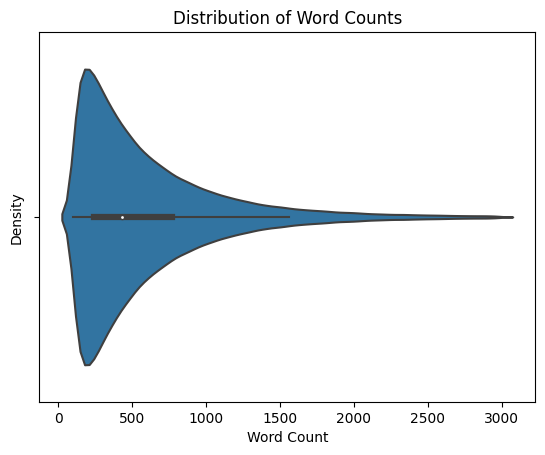

In [ ]:
# Create the violin plot
#sns.violinplot(x=df_kickstarter['num_words'])

# Add points for outliers
# sns.stripplot(x=df_kickstarter['num_words'], color='black', size=4, jitter=True)

# Set labels and title
#plt.xlabel('Word Count')
#plt.ylabel('Density')
#plt.title('Distribution of Word Counts')

# Display the plot
#plt.show()

In [ ]:
#print(len(df_indiegogo.index))
#print(df_indiegogo['num_words'].mean())
#print(df_indiegogo['num_words'].std())

381919
550.4595031930854
414.85098173905044


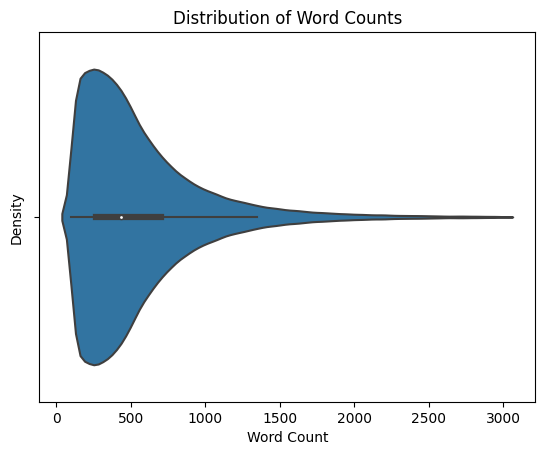

In [ ]:
# Create the violin plot
#sns.violinplot(x=df_indiegogo['num_words'])

# Add points for outliers
# sns.stripplot(x=df_kickstarter['num_words'], color='black', size=4, jitter=True)

# Set labels and title
#plt.xlabel('Word Count')
#plt.ylabel('Density')
#plt.title('Distribution of Word Counts')

# Display the plot
#plt.show()

# LDA

## Kickstarter

In [ ]:
# Copy Dataframe
df_lda_kickstarter = df_kickstarter.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Remove the columns
df_lda_kickstarter.drop(df_lda_kickstarter.columns.difference(['project_description', 'project_category_id', 'project_parent_category_id', 'project_state']), axis=1,inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Technology Category

In [ ]:
df_lda_kickstarter_technology = df_lda_kickstarter.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Filter Dataframe by Technology category (number 16)
df_lda_kickstarter_technology = df_lda_kickstarter_technology[(df_lda_kickstarter_technology['project_category_id'] == 16) | (df_lda_kickstarter_technology['project_parent_category_id'] == 16)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Preprocessing general steps
nltk.download('stopwords')
nltk.download('wordnet')
df_lda_kickstarter_technology['project_description'] = df_lda_kickstarter_technology['project_description'].progress_apply(preprocess_text_helper)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  0%|          | 0/26670 [00:00<?, ?it/s]

In [ ]:
data_technology = df_lda_kickstarter_technology['project_description'].tolist()
# Compute n-grams
from gensim.models import Phrases

# Add n-grams to docs (only ones that appear 20 times or more).
ngrams_technology = Phrases(data_technology, min_count=20)
for idx in range(len(data_technology)):
    for token in ngrams_technology[data_technology[idx]]:
        if '_' in token:
            # Token is a n-grams, add to document.
            data_technology[idx].append(token)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# create dictionary
dictionary_technology = corpora.Dictionary(data_technology)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Filter out words that occur less than 5 documents, or more than 50% of the documents.
dictionary_technology.filter_extremes(no_below=5, no_above=0.5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define your custom stoplist
custom_stoplist_technology = ["project", "kickstarter", "pledge", "backer", "campaign", "product"] #to be extended
# Add your custom stop words to the dictionary
stop_ids_technology = [dictionary_technology.token2id[word] for word in custom_stoplist_technology if word in dictionary_technology.token2id]
# Remove the stop words from the dictionary
dictionary_technology.filter_tokens(bad_ids=stop_ids_technology)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# create corpus
corpus_technology = [dictionary_technology.doc2bow(tokens) for tokens in data_technology]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from collections import Counter

# Count word occurrences
word_counts_technology = Counter()
for doc in corpus_technology:
    for word_id, count in doc:
        word = dictionary_technology[word_id]
        word_counts_technology[word] += count

# Get most frequent words
most_common_technology = word_counts_technology.most_common(100)
print(most_common_technology)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('app', 47281), ('design', 33740), ('user', 32928), ('new', 30999), ('people', 29622), ('device', 29559), ('want', 28965), ('system', 27115), ('see', 26268), ('play', 25998), ('year', 25859), ('first', 25285), ('way', 24996), ('video', 24374), ('would', 23337), ('sound', 23235), ('power', 22847), ('world', 22760), ('technology', 22467), ('using', 22066), ('support', 21770), ('many', 20881), ('feature', 20264), ('create', 20149), ('even', 20118), ('phone', 20038), ('goal', 19830), ('take', 19484), ('experience', 18890), ('light', 18450), ('life', 18437), ('used', 18229), ('able', 18142), ('team', 17880), ('well', 17814), ('part', 17377), ('development', 16720), ('day', 16717), ('battery', 16711), ('prototype', 16492), ('software', 16484), ('every', 16457), ('easy', 16424), ('know', 16366), ('data', 16300), ('business', 16164), ('control', 16093), ('home', 16046), ('cost', 16021), ('high', 15991), ('free', 15854), ('available', 15818), ('come', 15788), ('two', 15417), ('designed', 15071

In [ ]:
print('Number of unique tokens: %d' % len(dictionary_technology))
print('Number of documents: %d' % len(corpus_technology))

Number of unique tokens: 35933
Number of documents: 26670


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Initialize an empty list to store the LDA models
lda_models_technology = []

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Iterate over the desired topic counts from 10 to 300 in steps of 10
for num_topics in tqdm(range(10, 301, 10)):
    # Create an LDA model with the current topic count
    #lda_model = gensim.models.LdaMulticore(corpus=corpus_technology, id2word=dictionary_technology, num_topics=num_topics, passes=30, workers=8, per_word_topics=True, chunksize=100, iterations=150, eval_every=None, gamma_threshold=0.001)
    lda_model = gensim.models.LdaMulticore(corpus=corpus_technology, id2word=dictionary_technology, num_topics=num_topics, passes=20, workers=8,  per_word_topics=True, chunksize=100, iterations=100,  eval_every=None, gamma_threshold=0.001)

    # Save the model to Google Drive
    model_path = f"./drive/MyDrive/Colab Notebooks/Thesis Data/lda_technology/{num_topics}/lda_model_technology_{num_topics}"
    lda_model.save(model_path)

    # Append the model path to the list
    lda_models_technology.append(lda_model)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/30 [00:00<?, ?it/s]

Process ForkPoolWorker-22:
Process ForkPoolWorker-18:
Traceback (most recent call last):
Process ForkPoolWorker-19:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-17:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/gensim/models/ldamulticore.py", line 344, in worker_e_step
    worker_lda.sync_state()
Process ForkPoolWorker-21:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-24:
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
Traceback (most recent call last):
Process ForkPoolWorker-23:
  File "/usr/lib/python3.10/multiproce

KeyboardInterrupt: ignored

In [ ]:
# Loop through the created LDA models
for num_topics, lda_model in zip(range(10, 301, 10), lda_models_technology):
    # Create the visualization
    vis = gensimvis.prepare(lda_model, corpus_technology, dictionary_technology)

    # Save the visualization as an HTML file
    html_path = f"./drive/MyDrive/Colab Notebooks/Thesis Data/lda_technology/{num_topics}/lda_vis_technology_{num_topics}.html"
    pyLDAvis.save_html(vis, html_path)

### Games Category

In [ ]:
df_lda_kickstarter_games = df_lda_kickstarter.copy()

In [ ]:
# Filter Dataframe by Games category (number 12)
df_lda_kickstarter_games = df_lda_kickstarter_games[(df_lda_kickstarter_games['project_category_id'] == 12) | (df_lda_kickstarter_games['project_parent_category_id'] == 12)]

In [ ]:
# Preprocessing
df_lda_kickstarter_games['project_description'] = df_lda_kickstarter_games['project_description'].progress_apply(preprocess_text_helper)

In [ ]:
data_games = df_lda_kickstarter_games['project_description'].tolist()
# Compute bigrams/trigrams
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
ngrams_games = Phrases(data_games, min_count=20)
for idx in range(len(data_games)):
    for token in ngrams_games[data_games[idx]]:
        if '_' in token:
            # Token is a bigram/trigram, add to document.
            data_games[idx].append(token)

In [ ]:
# create dictionary
dictionary_games = corpora.Dictionary(data_games)

In [ ]:
# Filter out words that occur less than 5 documents, or more than 50% of the documents.
dictionary_games.filter_extremes(no_below=5, no_above=0.5)

In [ ]:
# Define your custom stoplist
custom_stoplist_games = ["project", "kickstarter", "pledge", "backer", "campaign", "product"] #to be extended
# Add your custom stop words to the dictionary
stop_ids_games = [dictionary_games.token2id[word] for word in custom_stoplist_games if word in dictionary_games.token2id]
# Remove the stop words from the dictionary
dictionary_technology.filter_tokens(bad_ids=stop_ids_games)

In [ ]:
# create corpus
corpus_games = [dictionary_games.doc2bow(tokens) for tokens in data_games]

In [ ]:
from collections import Counter

# Count word occurrences
word_counts_games = Counter()
for doc in corpus_games:
    for word_id, count in doc:
        word = dictionary_games[word_id]
        word_counts_games[word] += count

# Get most frequent words
most_common_games = word_counts_games.most_common(100)
print(most_common_games)

In [ ]:
print('Number of unique tokens: %d' % len(dictionary_games))
print('Number of documents: %d' % len(corpus_games))

Number of unique tokens: 52992
Number of documents: 38517


In [ ]:
# Initialize an empty list to store the LDA models
lda_models_games = []

In [ ]:
# Iterate over the desired topic counts from 10 to 300 in steps of 10
for num_topics in range(10, 301, 10):
    # Create an LDA model with the current topic count
    lda_model = gensim.models.LdaMulticore(corpus=corpus_games, id2word=dictionary_games, num_topics=num_topics, passes=30, workers=8, per_word_topics=True, chunksize=100, iterations=150, eval_every=None, gamma_threshold=0.001)

    # Save the model to Google Drive
    model_path = f"./drive/MyDrive/Colab Notebooks/Thesis Data/lda_games/{num_topics}/lda_model_games_{num_topics}"
    lda_model.save(model_path)

    # Append the model path to the list
    lda_models_games.append(lda_model)

In [ ]:
# Loop through the created LDA models
for num_topics, lda_model in zip(range(10, 301, 10), lda_models_games):
    # Create the visualization
    vis = gensimvis.prepare(lda_model, corpus_games, dictionary_games)

    # Save the visualization as an HTML file
    html_path = f"./drive/MyDrive/Colab Notebooks/Thesis Data/lda_games/{num_topics}/lda_vis_games_{num_topics}.html"
    pyLDAvis.save_html(vis, html_path)

### Design Category

In [ ]:
df_lda_kickstarter_design = df_lda_kickstarter.copy()

In [ ]:
# Filter Dataframe by Design category (number 7)
df_lda_kickstarter_design = df_lda_kickstarter_design[(df_lda_kickstarter_design['project_category_id'] == 7) | (df_lda_kickstarter_design['project_parent_category_id'] == 7)]

In [ ]:
# Preprocessing general steps
nltk.download('stopwords')
nltk.download('wordnet')
df_lda_kickstarter_design['project_description'] = df_lda_kickstarter_design['project_description'].progress_apply(preprocess_text_helper)

In [ ]:
data_design = df_lda_kickstarter_design['project_description'].tolist()
# Compute n-grams
from gensim.models import Phrases

# Add n-grams to docs (only ones that appear 20 times or more).
ngrams_design = Phrases(data_design, min_count=20)
for idx in range(len(data_design)):
    for token in ngrams_design[data_design[idx]]:
        if '_' in token:
            # Token is a n-grams, add to document.
            data_design[idx].append(token)

In [ ]:
# create dictionary
dictionary_design = corpora.Dictionary(data_design)

In [ ]:
# Filter out words that occur less than 5 documents, or more than 50% of the documents.
dictionary_design.filter_extremes(no_below=5, no_above=0.5)

In [ ]:
# Define your custom stoplist
custom_stoplist_design = ["project", "kickstarter", "pledge", "backer", "campaign", "product"] #to be extended
# Add your custom stop words to the dictionary
stop_ids_design = [dictionary_design.token2id[word] for word in custom_stoplist_design if word in dictionary_design.token2id]
# Remove the stop words from the dictionary
dictionary_design.filter_tokens(bad_ids=stop_ids_design)

In [ ]:
# create corpus
corpus_design = [dictionary_design.doc2bow(tokens) for tokens in data_design]

In [ ]:
from collections import Counter

# Count word occurrences
word_counts_design = Counter()
for doc in corpus_design:
    for word_id, count in doc:
        word = dictionary_design[word_id]
        word_counts_design[word] += count

# Get most frequent words
most_common_design = word_counts_design.most_common(100)
print(most_common_design)

[('new', 32367), ('work', 29194), ('year', 28898), ('want', 25475), ('way', 25283), ('color', 25185), ('production', 24839), ('material', 24461), ('see', 24329), ('would', 23932), ('back', 23118), ('designed', 23104), ('goal', 22942), ('hand', 22693), ('reward', 22506), ('play', 22051), ('prototype', 21519), ('bag', 21382), ('come', 21146), ('many', 21114), ('quality', 20950), ('two', 20792), ('people', 20699), ('take', 20509), ('support', 20427), ('day', 20303), ('campaign', 19860), ('life', 19430), ('used', 19264), ('every', 19154), ('great', 19000), ('world', 18949), ('even', 18935), ('size', 18421), ('well', 18404), ('set', 17968), ('keep', 17680), ('easy', 17666), ('using', 17495), ('case', 17485), ('high', 17430), ('sound', 17411), ('create', 17342), ('order', 17257), ('shipping', 17061), ('water', 17019), ('part', 17006), ('card', 16689), ('love', 16642), ('idea', 16005), ('look', 15893), ('best', 15721), ('available', 15532), ('add', 15461), ('light', 15401), ('different', 1529

In [ ]:
print('Number of unique tokens: %d' % len(dictionary_design))
print('Number of documents: %d' % len(corpus_design))

Number of unique tokens: 39472
Number of documents: 28092


In [ ]:
# Initialize an empty list to store the LDA models
lda_models_design = []

In [ ]:
# Iterate over the desired topic counts from 10 to 300 in steps of 10
for num_topics in tqdm(range(10, 301, 10)):
    # Create an LDA model with the current topic count
    lda_model = gensim.models.LdaMulticore(corpus=corpus_design, id2word=dictionary_design, num_topics=num_topics, passes=30, workers=8, per_word_topics=True, chunksize=100, iterations=150, eval_every=None, gamma_threshold=0.001)

    # Save the model to Google Drive
    model_path = f"./drive/MyDrive/Colab Notebooks/Thesis Data/lda_design/{num_topics}/lda_model_design_{num_topics}"
    lda_model.save(model_path)

    # Append the model path to the list
    lda_models_design.append(lda_model)

In [ ]:
# Loop through the created LDA models
for num_topics, lda_model in zip(range(10, 301, 10), lda_models_design):
    # Create the visualization
    vis = gensimvis.prepare(lda_model, corpus_design, dictionary_design)

    # Save the visualization as an HTML file
    html_path = f"./drive/MyDrive/Colab Notebooks/Thesis Data/lda_design/{num_topics}/lda_vis_design_{num_topics}.html"
    pyLDAvis.save_html(vis, html_path)

## Indiegogo

In [ ]:
# Copy Dataframe
df_lda_indiegogo = df_indiegogo.copy()

In [ ]:
# Remove the columns
df_lda_indiegogo.drop(df_lda_indiegogo.columns.difference(['project_description', 'project_category_id', 'project_goal', 'project_collected_funds']), axis=1,inplace=True)

In [ ]:
value_counts = df_lda_indiegogo['project_category_id'].value_counts()
for value, count in value_counts.items():
    print(f"{value}: {count}")


56.0: 88459
69.0: 53742
64.0: 52174
65.0: 32826
57.0: 30021
49.0: 18624
58.0: 15754
55.0: 13985
60.0: 12593
53.0: 9285
77.0: 7206
62.0: 5910
45.0: 5137
68.0: 4622
59.0: 3911
51.0: 3315
48.0: 3155
54.0: 3019
71.0: 2547
72.0: 2318
50.0: 1905
63.0: 1572
61.0: 1556
52.0: 1515
66.0: 1256
67.0: 1168
70.0: 833
46.0: 781
74.0: 741
75.0: 656
47.0: 650
73.0: 615
76.0: 68


# BERTopic

## Kickstarter

In [ ]:
# Copy Dataframe
df_bertopic_kickstarter = df_kickstarter.copy()

In [ ]:
# Remove the columns
df_bertopic_kickstarter.drop(df_bertopic_kickstarter.columns.difference(['project_description', 'project_category_id', 'project_parent_category_id', 'project_state']), axis=1,inplace=True)

### Technology Category

In [ ]:
df_bertopic_kickstarter_technology = df_bertopic_kickstarter.copy()

In [ ]:
# Filter Dataframe by Technology category (number 16)
df_bertopic_kickstarter_technology = df_bertopic_kickstarter_technology[(df_bertopic_kickstarter_technology['project_category_id'] == 16) | (df_bertopic_kickstarter_technology['project_parent_category_id'] == 16)]

In [ ]:
from bertopic.vectorizers import ClassTfidfTransformer

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
#vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(ctfidf_model=ctfidf_model, language="english", calculate_probabilities=True, verbose=True, n_gram_range=(1,2))
topics, probs = topic_model.fit_transform(df_bertopic_kickstarter_technology['project_description'].tolist())

Batches:   0%|          | 0/834 [00:00<?, ?it/s]

2023-06-14 15:16:50,308 - BERTopic - Transformed documents to Embeddings
2023-06-14 15:17:17,308 - BERTopic - Reduced dimensionality
2023-06-14 15:19:39,159 - BERTopic - Clustered reduced embeddings


In [ ]:
topic_model.save('./drive/MyDrive/Colab Notebooks/Thesis Data/bertopic/bertopic_technology_ClassTfidfTransformer')

### Visualization of Topics 'CountVectorizer'

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=300)

In [ ]:
topic_model.visualize_barchart(top_n_topics=300)

In [ ]:
freq = topic_model.get_topic_info(); freq.head(300)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11143,-1_app_use_project_time,"[app, use, project, time, make, help, need, pe...",[YOUR STORY: • Have you clearly communicated ...
1,0,625,0_light_led_lights_lighting,"[light, led, lights, lighting, leds, color, br...",[Tired of tripping over things in the dark at ...
2,1,475,1_security_files_data_secure,"[security, files, data, secure, storage, drive...","[WHAT IS RSVP? Really Simple, Very Powerful (..."
3,2,432,2_fitness_workout_gym_exercise,"[fitness, workout, gym, exercise, workouts, tr...",[ WHAT IS LINK TO FITNESS?Link To Fitness is a...
4,3,429,3_3d_printer_printing_print,"[3d, printer, printing, print, printers, filam...",[Intro i-SOLIDS is a community driven 3D prin...
...,...,...,...,...,...
277,276,10,276_treyner_roadie_fret_guitar,"[treyner, roadie, fret, guitar, jamstik, instr...",[Experience your guitar in a completely new li...
278,277,10,277_kasi_miaokids_atoms_kiri,"[kasi, miaokids, atoms, kiri, games, webee, bo...",[TheSmartBox - the world's first learning tool...
279,278,10,278_icoil_evolt365_charlie_flexpand,"[icoil, evolt365, charlie, flexpand, variation...","[Reclaim your outlets with FLEXPAND POWER, a f..."
280,279,10,279_wedding_couples_matchology_wedistry,"[wedding, couples, matchology, wedistry, flori...",[Wedding Grid 3 Phones Examples Working i...


### Visualization of Topics 'ClassTfidfTransformer'

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=300)

In [ ]:
topic_model.visualize_barchart(top_n_topics=300)

In [ ]:
freq = topic_model.get_topic_info(); freq.head(300)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11089,-1_my_project_would_will be,"[my, project, would, will be, users, people, w...",[ Today we have an universal audio jack that h...
1,0,750,0_light_lights_lighting_led,"[light, lights, lighting, led, leds, the light...",[Tired of tripping over things in the dark at ...
2,1,470,1_security_files_encryption_passwords,"[security, files, encryption, passwords, passw...",[ALL YOUR Photos and Videos safely BACKED UP a...
3,2,396,2_fitness_workout_gym_workouts,"[fitness, workout, gym, workouts, exercise, he...",[Introducing NANO Fitness Smart Training Suit:...
4,3,313,3_guitar_midi_pedal_instrument,"[guitar, midi, pedal, instrument, guitars, ped...",[Check out the official Klein Bottle demo by Y...
...,...,...,...,...,...
286,285,10,285_massquerade_theory_gravity_cmyr,"[massquerade, theory, gravity, cmyr, massquera...","[PLAY\n\nWelcome.\n\nHi today, Tuesday Jan 26,..."
287,286,10,286_sideline_krazyride_sideline sos_goroundit,"[sideline, krazyride, sideline sos, goroundit,...",[INTRODUCING: SIDELINE SOS The World’s First ...
288,287,10,287_miaokids_kiri_webee_kidx,"[miaokids, kiri, webee, kidx, montessori, smar...",[TheSmartBox - the world's first learning tool...
289,288,10,288_pool_cua_the pool_your pool,"[pool, cua, the pool, your pool, seagull 3000,...","[Owning a pool is supposed to be relaxing, but..."


## Indiegogo